## TODO:
- Implement "harvest rain"
- Check with TL harvest dates
- Implement floraison period


,debourrement,mi-floraison M,mi-floraison CS,veraison,vendanges,deb vendanges,fin vendanges,floraison,nouaison,debut floraison,fin floraison,Debourrement-floraison interval,Floraison-veraison interval,Veraison-Harvest interval,Growing season duration
vintage,,,,,,,,,,,,,,,
1961,1961-03-10,1961-05-29,1961-05-29,1961-08-08,1961-09-23,1961-09-19,1961-09-28,1961-05-29,1961-06-13,1961-05-22,1961-06-05,80,71,46,197
1962,1962-04-18,1962-06-15,1962-06-15,1962-08-18,1962-10-10,1962-10-01,1962-10-20,1962-06-15,1962-06-30,1962-06-08,1962-06-22,58,64,53,175
1963,1963-04-10,1963-06-18,1963-06-18,1963-08-15,1963-10-16,1963-10-10,1963-10-23,1963-06-18,1963-07-03,1963-06-11,1963-06-25,69,58,62,189
1964,1964-04-05,1964-06-14,1964-06-14,1964-08-13,1964-10-01,1964-09-25,1964-10-08,1964-06-14,1964-06-29,1964-06-07,1964-06-21,70,60,49,179
1965,1965-03-31,1965-06-28,1965-06-28,1965-08-15,1965-10-10,1965-10-04,1965-10-16,1965-06-28,1965-07-13,1965-06-21,1965-07-05,89,48,56,193


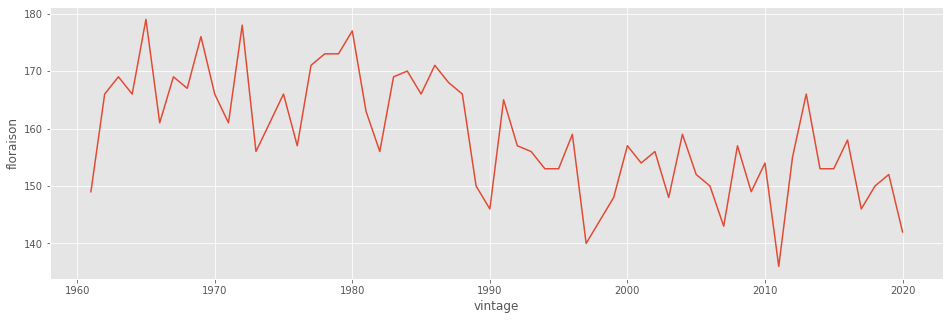

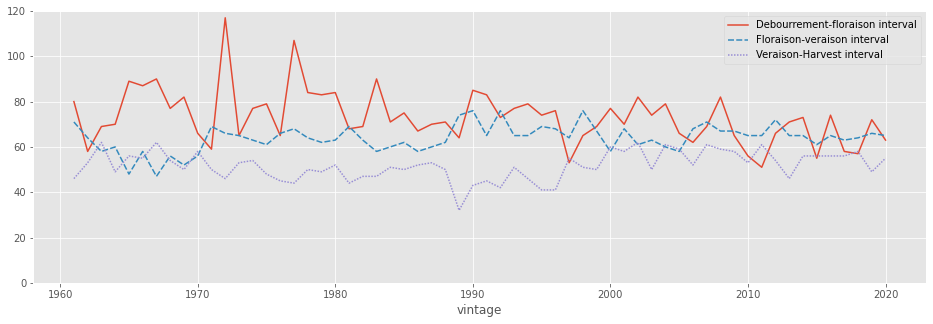

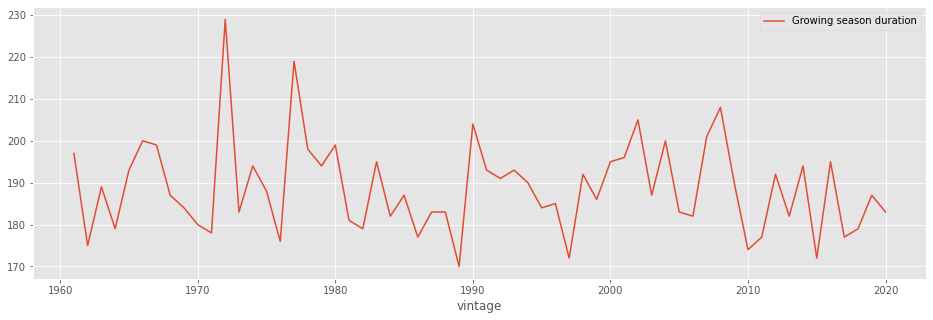

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 5)

pheno = pd.read_excel('data/pheno_latour.xlsx', index_col=0)
pheno['floraison'] = pheno['mi-floraison M']

pheno['vendanges'] = pd.to_datetime(pheno['vendanges'].dt.date)
pheno['veraison'] = pd.to_datetime(pheno['veraison'].dt.date)
pheno['nouaison'] = pheno['floraison'] + datetime.timedelta(days=15)
pheno['debut floraison'] = pheno['floraison'] - datetime.timedelta(days=7)
pheno['fin floraison'] = pheno['floraison'] + datetime.timedelta(days=7)


pheno['Debourrement-floraison interval'] = (pheno['floraison'] - pheno['debourrement']).dt.days
pheno['Floraison-veraison interval'] = (pheno['veraison'] - pheno['floraison']).dt.days
pheno['Veraison-Harvest interval'] = (pheno['vendanges'] - pheno['veraison']).dt.days
pheno['Growing season duration'] = (pheno['vendanges'] - pheno['debourrement']).dt.days

display(pheno.head())

sns.lineplot(data=(pheno['floraison'].dt.dayofyear))
plt.show()

intervalles = pheno[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']]
plt.ylim((0,120))
sns.lineplot(data=intervalles)
plt.show()

sns.lineplot(data=pheno[['Growing season duration']])
plt.show()

In [68]:
weather = pd.read_csv('data/weather_merignac_daily.csv', parse_dates=['Date']).set_index('Date')
weather['Frost'] = (weather['Tn'] < 0).astype(int)
weather['DTR'] = weather['Tx'] - weather['Tn']
weather['CI'] = (weather['Tn'] < 15).astype(int)
weather['Huglin'] = ((weather['Tx']-10) + (weather['Tm']-10))/2
weather['Heavy Rain'] = (weather['P'] > 15).astype(int)
weather['Stress'] = 0.5*weather['ETPmon'] - weather['P']
ORIG_WEATHER_FEATURES = list(weather.columns)
weather['Tm-25'] = (weather['Tx']<30).astype(int) * (weather['Tm']>20).astype(int)
weather['GDD10'] = ((weather['Tx']+weather['Tx'])/2 > 10).astype(int) * ((weather['Tx']+weather['Tx'])/2 - 10)

In [73]:
import datetime

vintages = list(pheno.index)

df = pd.DataFrame(index = vintages)
events = ['debourrement', 'floraison', 'veraison', 'vendanges']

# Adding all base features
for feature in ORIG_WEATHER_FEATURES:
    intervals = [[events[i], events[i+1]] for i in range(len(events)-1)]

    subfeatures_list = [feature + ': '+ interval[0] + ' - ' + interval[1] for interval in intervals]
    for subfeature in subfeatures_list:
        df[subfeature] = 0

    for interval in intervals:
        feature_name = feature + ': '+ interval[0] + ' - ' + interval[1]
        for vintage in vintages:
            date_begin, date_end = pheno.loc[vintage, interval[0]], pheno.loc[vintage, interval[1]]
            if feature in ['P', 'Sun', 'Hail', 'ETPmon', 'Wind', 'Frost', 'GDD10', 'Stress']:
                df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].sum()  
            
                
            #elif feature == 'GDD':
            #    date_debourrement = pheno.loc[vintage, 'debourrement']
            #    df.loc[vintage, feature_name] = weather.loc[date_debourrement:date_end, feature].sum()           
            else:
                df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].mean()
                

#### Adding other features

# Early frost: from October to November
df['Prev Fall Frost'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 9, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage - 1, 11, 1) # End in December
    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
           
    date_begin = datetime.date(vintage - 1, 11, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage - 1, 12, 1) # End in December
    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
    
# Early frost: from October to November
df['Winter Frost'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 12, 1) # Begin on Dec 1, previous year
    date_end = pheno.loc[vintage, 'debourrement'] - datetime.timedelta(days=15) # End in Feb
    df.loc[vintage, 'Winter Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
           
# Winter Tm
df['Winter Tn'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 12, 15) # Begin on October 1, previous year
    date_end = datetime.date(vintage , 3, 1) # End mid March
    df.loc[vintage, 'Winter Tn'] += weather.loc[date_begin:date_end, 'Tn'].mean()

df['Winter Rain'] = 0
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage , 3, 1) # End mid March
    df.loc[vintage, 'Winter Rain'] += weather.loc[date_begin:date_end, 'P'].mean()

# Winter Tm
df['Debourrement date'] = pheno['debourrement'].dt.dayofyear
df['Floraison date'] = pheno['floraison'].dt.dayofyear
df['Veraison date'] = pheno['veraison'].dt.dayofyear
df['Harvest date'] = pheno['vendanges'].dt.dayofyear

df['Dormancy'] = 0
weather['CD'] = (weather['Tm'] <= 7.2).astype(int)
for vintage in vintages[1:]: # do not include first vintage
    date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
    date_end = datetime.date(vintage , 3, 1) # End mid March
    
    df.loc[vintage, 'Dormancy'] += ((weather.loc[date_begin:date_end, 'CD'] * weather.loc[date_begin:date_end, 'CD'].shift(1) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(2) * weather.loc[date_begin:date_end, 'CD'].shift(3) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(4) * weather.loc[date_begin:date_end, 'CD'].shift(5) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(6) * weather.loc[date_begin:date_end, 'CD'].shift(7) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(8) * weather.loc[date_begin:date_end, 'CD'].shift(9) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(10) * weather.loc[date_begin:date_end, 'CD'].shift(11) *\
                                    weather.loc[date_begin:date_end, 'CD'].shift(12) * weather.loc[date_begin:date_end, 'CD'].shift(13)).sum() > 0).astype(int)
    
    
df['Harvest Rain'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'deb vendanges'] - datetime.timedelta(days=7)
    date_end = pheno.loc[vintage, 'fin vendanges'] - datetime.timedelta(days=15)
    df.loc[vintage, 'Harvest Rain'] = weather.loc[date_begin:date_end, 'P'].sum()

# Floraison conditions
df['Floraison Wind'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison Wind'] += ((weather.loc[date_begin:date_end, 'Wind'])).mean()
    
df['Floraison P'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison P'] += (weather.loc[date_begin:date_end, 'P']).sum()
    
df['Floraison Tm'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison Tm'] += (weather.loc[date_begin:date_end, 'Tm']).sum()

#Vend et precip 0
#Temp pas au dessus de 25


df['Floraison Tm-25'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = pheno.loc[vintage, 'debut floraison']
    date_end = pheno.loc[vintage, 'fin floraison']
    df.loc[vintage, 'Floraison Tm-25'] += (weather.loc[date_begin:date_end, 'Tm-25']).sum()
    
df['GDD10'] = 0
for vintage in vintages: # do not include first vintage
    date_begin = datetime.date(vintage, 4, 1)
    date_end = pheno.loc[vintage, 'vendanges']
    df.loc[vintage, 'GDD10'] += (weather.loc[date_begin:date_end, 'GDD10']).sum()
    
#df['Enough GDD10'] = (df['GDD10'] > 2530).astype(int)
df = df.drop(['Frost: floraison - veraison', 'Frost: veraison - vendanges'], axis=1)
display(df)

,P: debourrement - floraison,P: floraison - veraison,P: veraison - vendanges,Tn: debourrement - floraison,Tn: floraison - veraison,Tn: veraison - vendanges,Tx: debourrement - floraison,Tx: floraison - veraison,Tx: veraison - vendanges,Tm: debourrement - floraison,...,Floraison date,Veraison date,Harvest date,Dormancy,Harvest Rain,Floraison Wind,Floraison P,Floraison Tm,Floraison Tm-25,GDD10
1961,108.1,115.2,13.9,7.197531,13.404167,13.940426,18.328395,23.823611,25.674468,12.606173,...,149,220,266,0,0.0,2.753333,45.2,211.3,0,2245.9
1962,92.5,77.3,90.6,9.028814,13.676923,11.901852,19.383051,24.992308,24.459259,14.201695,...,166,230,283,0,77.6,2.313333,19.6,279.2,4,2328.9
1963,156.4,125.6,146.5,8.962857,13.994915,11.726984,18.821429,23.569492,20.076190,13.800000,...,169,227,289,1,14.8,3.173333,3.1,260.1,1,2068.2
1964,158.3,43.2,98.9,9.638028,13.713115,13.916000,19.998592,25.593443,24.876000,14.692958,...,166,226,275,1,0.3,2.786667,1.5,254.5,0,2388.7
1965,141.3,63.5,278.4,9.055556,13.461224,12.073684,18.291111,23.989796,20.459649,13.584444,...,179,227,283,1,60.0,3.366667,25.5,276.4,2,1988.8
1966,196.7,150.5,74.0,7.959091,13.079661,13.076786,18.073864,22.371186,24.582143,12.904545,...,161,219,274,0,0.0,3.053333,69.2,274.9,4,2184.0
1967,178.9,17.9,134.6,7.020879,14.175000,12.233333,17.954945,25.993750,23.447619,12.374725,...,169,216,278,1,6.3,3.673333,5.0,254.8,1,2279.0
1968,198.4,123.0,246.7,7.530769,13.492982,12.620000,18.712821,25.075439,22.694545,13.092308,...,167,223,277,1,43.5,3.346667,65.0,249.1,0,2201.6
1969,317.7,61.3,205.4,9.287952,14.660377,11.739216,19.022892,26.990566,21.678431,14.095181,...,176,228,278,1,0.0,3.600000,68.2,258.3,2,2230.0
1970,141.9,60.1,86.0,9.135821,13.877193,12.335593,20.129851,25.547368,24.411864,14.610448,...,166,222,280,1,7.6,2.386667,40.6,284.7,4,2401.5


In [74]:
df[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']] = pheno[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']]
prices = pd.read_excel('data/generated_average_prices.xlsx', index_col=0)
display(prices.head())

df['Tm Growing Season'] = df['Tm: debourrement - floraison'] + df['Tm: floraison - veraison'] + df['Tm: veraison - vendanges']

df['Stress'] = 0.5*(df['ETPmon: floraison - veraison'] + df['ETPmon: veraison - vendanges']) - (df['P: floraison - veraison'] + df['P: veraison - vendanges'])
df['Stress'] = (df['Stress'] > -150).astype(int) * df['Stress']
df['Huglin Growing Season'] = df['Huglin: debourrement - floraison'] + df['Huglin: floraison - veraison'] + df['Huglin: veraison - vendanges']

df['Log price'] = np.log(prices['Price'])
df['Floraison P'] = (df['Floraison P'] > 30).astype(int) * df['Floraison P']

df.to_excel('data/generated_daily_features.xlsx')

,Price
Vintage,
1950,479.821429
1951,701.875000
1952,243.000000
1953,679.178571
1954,721.000000


Log price                           1.000000
Veraison date                       0.720941
Harvest date                        0.705652
Stress: veraison - vendanges        0.688006
CI: debourrement - floraison        0.677609
Stress                              0.653521
P: veraison - vendanges             0.650148
Heavy Rain: veraison - vendanges    0.631435
Floraison date                      0.627076
Pr: veraison - vendanges            0.579782
Winter Frost                        0.548028
Huglin Growing Season               0.545982
DTR: debourrement - floraison       0.515700
Tm Growing Season                   0.494560
Tm: floraison - veraison            0.484373
DTR: veraison - vendanges           0.483381
ETPmon: floraison - veraison        0.465186
Pr: floraison - veraison            0.462143
Huglin: floraison - veraison        0.457126
Harvest Rain                        0.449748
Tx: veraison - vendanges            0.436260
Winter Tn                           0.433664
Tx: florai

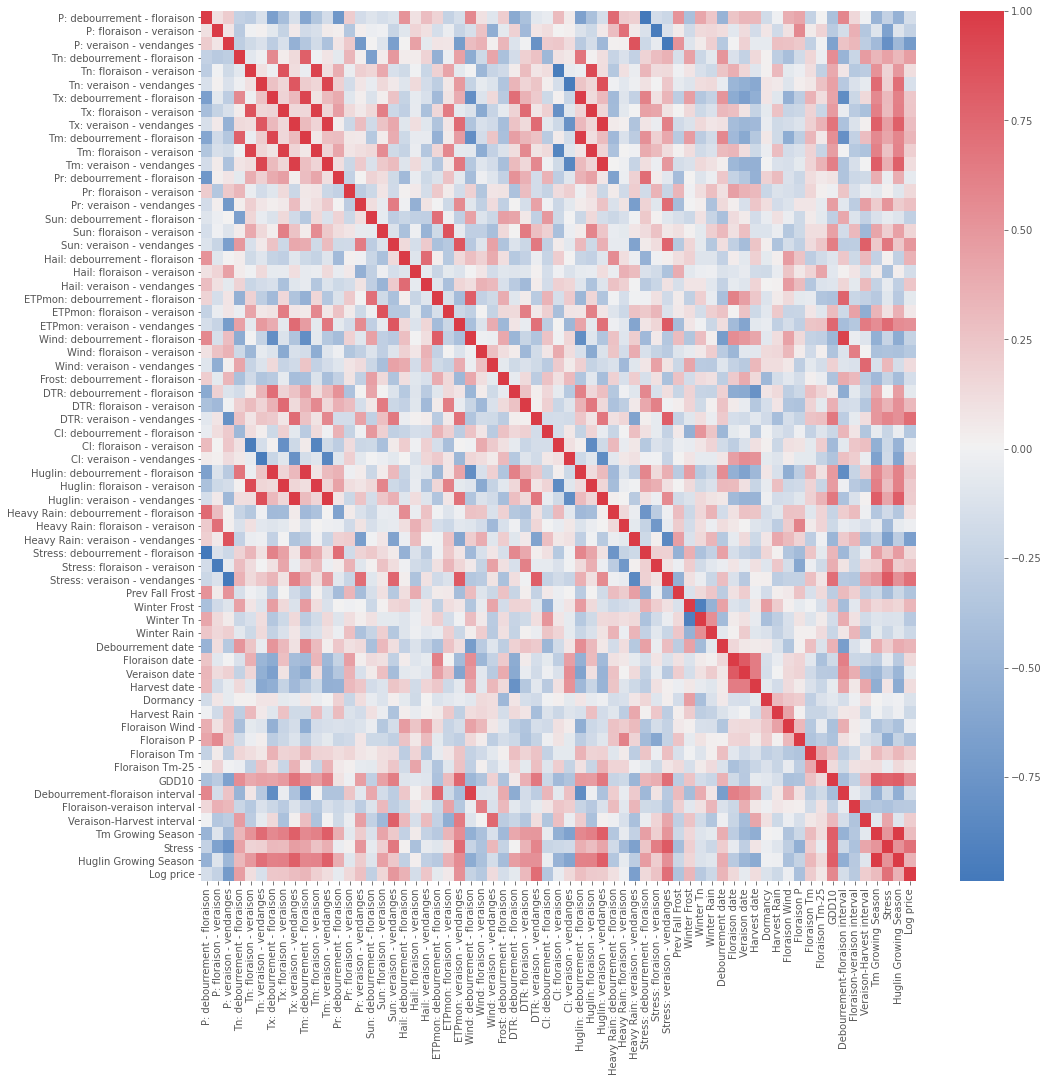

In [76]:

display(df.loc[1980:1993, :].corr()['Log price'].abs().nlargest(40))
plt.figure(figsize=(16,16))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(df.loc[1994:, :].corr(), cmap=cmap)
plt.show()




In [7]:
from scipy.stats import pearsonr
from sklearn.ensemble import ExtraTreesRegressor

features = list(df.columns)
features.remove('Log price')
periods = [year for year in range(1961, 1979)]
correlations = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)
pvals = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)
importances = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)

for year in range(1961, 1979):
    for feature in features:
        X_train, y_train = df.loc[year:year+15, feature], df.loc[year:year+15, 'Log price']
        corr = pearsonr(X_train, y_train)
        
        correlations.loc[year, feature] = corr[0]
        pvals.loc[year, feature] = corr[1]
        
    X_train, y_train = df.loc[year:year+10, features], df.loc[year:year+10, 'Log price']
    model = ExtraTreesRegressor()
    model.fit(X_train.values, y_train.values)
    #print(model.feature_importances_)
    importances.loc[year, :] = model.feature_importances_
        
        
pvals_copy = pvals.loc[1970:, :].T
pvals_copy['mean'] = pvals_copy.mean(axis=1)
smallest_pvals = list(pvals_copy['mean'].nsmallest(40).index)


importances = importances.loc[1970:, :].T
importances['mean'] = importances.mean(axis=1)
largest_importances = list(importances['mean'].nlargest(5).index)

sns.lineplot(data=pvals[smallest_p_vals])
plt.show()

sns.lineplot(data=correlations[smallest_pvals])
plt.show()

product = correlations * (1-pvals)

plt.show()
product_copy = product.loc[1970:, :].T
product_copy['mean'] = product_copy.mean(axis=1)
a = (list(product_copy['mean'].nlargest(5).index))
b = (list(product_copy['mean'].nsmallest(5).index))
sns.lineplot(data=product[a+b])
plt.show()

NameError: name 'smallest_p_vals' is not defined

C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\Rico\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is co

Spearman top features:  ['Stress', 'DTR: veraison - vendanges', 'Stress: veraison - vendanges', 'Tm: floraison - veraison', 'P: veraison - vendanges', 'Huglin: floraison - veraison', 'Pr: veraison - vendanges', 'Tx: floraison - veraison', 'Heavy Rain: veraison - vendanges', 'CI: debourrement - floraison']


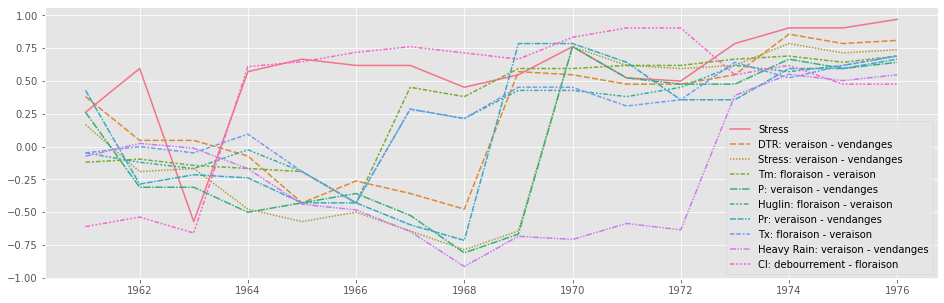

Spearman top features:  ['Stress', 'Huglin Growing Season', 'Stress: veraison - vendanges', 'Tm Growing Season', 'P: veraison - vendanges', 'DTR: veraison - vendanges', 'Veraison-Harvest interval', 'GDD10', 'Wind: veraison - vendanges', 'Tx: debourrement - floraison', 'CI: debourrement - floraison', 'Tm: floraison - veraison', 'Pr: veraison - vendanges', 'DTR: debourrement - floraison', 'Heavy Rain: veraison - vendanges', 'Floraison Tm', 'Huglin: debourrement - floraison', 'Wind: debourrement - floraison', 'Huglin: floraison - veraison', 'Wind: floraison - veraison', 'Debourrement-floraison interval', 'P: debourrement - floraison', 'Harvest Rain', 'Stress: debourrement - floraison', 'ETPmon: debourrement - floraison', 'Tx: floraison - veraison', 'Tn: floraison - veraison', 'Tm: debourrement - floraison', 'Heavy Rain: debourrement - floraison', 'Floraison Wind']


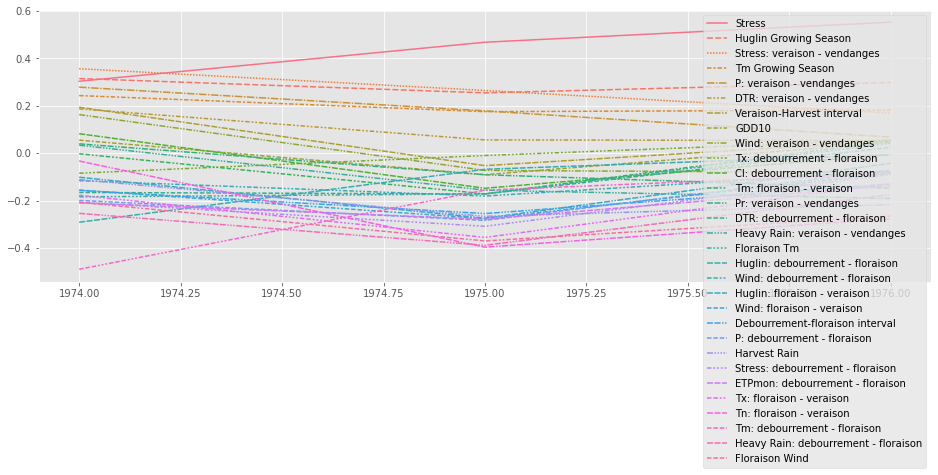

In [8]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, pearsonr

features = list(df.columns)
features.remove('Log price')
periods = [year for year in range(1961, 1977)]
rsq = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)
spe = pd.DataFrame(np.zeros((len(periods), len(features))),index = periods, columns = features)

for year in range(1961, 1977):
    for feature in features:
        X_train, y_train = df.loc[year:year+9, feature], df.loc[year:year+9, 'Log price']
        X_test, y_test = df.loc[year+10:year+17, feature], df.loc[year+10:year+17, 'Log price']

        
        mod = LinearRegression()
        mod.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))
        pred = mod.predict(X_test.values.reshape(-1,1))
        spe.loc[year, feature] = spearmanr(y_test, pred).correlation

        spe.loc[year, feature] = spearmanr(y_test, pred).correlation
        rsq.loc[year, feature] = mod.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1))
        #print(spearmanr(y_test, pred).correlation)
        

spe_copy = spe.loc[1974:, :].T
spe_copy['mean'] = spe_copy.mean(axis=1)
largest_p_vals = list(spe_copy['mean'].nlargest(10).index)
print('Spearman top features: ',largest_p_vals)

sns.lineplot(data = spe[largest_p_vals])
plt.show()

rsq_copy = rsq.loc[1974:, :].T
rsq_copy['mean'] = rsq_copy.mean(axis=1)
largest_p_vals = list(rsq_copy['mean'].nlargest(30).index)
print('Spearman top features: ',largest_p_vals)

sns.lineplot(data = rsq.loc[1974:, largest_p_vals])
plt.show()

In [9]:
#sns.regplot(x = df['Floraison Tm Offset'], y = df['Log price'])
#plt.show()

#features = list(df.columns)
#features.remove('Log price')
#for orig_feature in ORIG_WEATHER_FEATURES:
#    print(orig_feature)
#    to_plot = [feature for feature in features if orig_feature+':' in feature]
#    fig, axes = plt.subplots(1, len(to_plot)+1)
#    
#    for i in range(len(to_plot)):
#        sns.regplot(ax = axes[i], x = df[to_plot[i]], y = df['Log price'])
#    plt.show()


In [31]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_selection import SelectFromModel

df_train=df.loc[1980:1993]
X_train = df_train.drop('Log price', axis=1).reset_index().rename(columns={'index':'vintage'})
y_train = df_train[['Log price']]
df_test=df.loc[2000:2017]
X_test = df_test.drop('Log price', axis=1).reset_index().rename(columns={'index':'vintage'})
y_test = df_test[['Log price']]

linreg = LinearRegression()
#forest = RandomForestRegressor(n_estimators=10, max_depth=10)
tree = RandomForestRegressor(n_estimators=30, max_depth=4)
rfe = RFE(linreg, n_features_to_select=10)
sel = SelectFromModel(estimator=LinearRegression())

rfe.fit(X_train,y_train.values.ravel())
sel.fit(X_train,y_train.values.ravel())

print(rfe.score(X_test,y_test))
supp = rfe.support_
supp2 = sel.get_support()#print(export_text(rfe.estimator_))

sel_features = []
for i in range(len(list(X_train.columns))):
    if supp[i]:
        sel_features.append(list(X_train.columns)[i])
print(sel_features)

sel_features = []
for i in range(len(list(X_train.columns))):
    if supp2[i]:
        sel_features.append(list(X_train.columns)[i])
print(sel_features)

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
sfs1 = sfs(linreg,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='r2', #'r2'
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train.values, y_train.values.reshape(-1,1))

feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

sel_features = []
for i in range(len(list(X_train.columns))):
    if i in feat_cols:
        sel_features.append(list(X_train.columns)[i])
print(sel_features)


X_train = X_train[sel_features]
X_test = X_test[sel_features]

linreg = LinearRegression()
linreg.fit(X_train, y_train.values.reshape(-1,1))
pred = linreg.predict(X_test)
print('Spearman: ', spearmanr(y_test, pred).correlation)

-0.8306778309292377
['P: veraison - vendanges', 'Pr: floraison - veraison', 'ETPmon: debourrement - floraison', 'Stress: debourrement - floraison', 'Winter Frost', 'Harvest Rain', 'Floraison Wind', 'Floraison P', 'Floraison Tm-25', 'Veraison-Harvest interval']
['P: veraison - vendanges', 'ETPmon: debourrement - floraison', 'ETPmon: floraison - veraison', 'ETPmon: veraison - vendanges', 'Wind: floraison - veraison', 'Stress: debourrement - floraison', 'Stress: floraison - veraison', 'Prev Fall Frost', 'Winter Frost', 'Harvest Rain', 'Floraison Wind', 'Floraison P', 'GDD10', 'Debourrement-floraison interval', 'Floraison-veraison interval', 'Stress']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.4s finished

[2021-06-15 15:37:27] Features: 1/5 -- score: -0.6146208894479751[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s finished

[2021-06-15 15:37:27] Features: 2/5 -- score: -0.24968778647457257[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.5s finished

[2021-06-15 15:37:28] Features: 3/5 -- score: -0.09103392571661957[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

[10, 20, 22, 55, 60]
['Tm: debourrement - floraison', 'Hail: floraison - veraison', 'ETPmon: debourrement - floraison', 'Debourrement-floraison interval', 'Huglin Growing Season']
Spearman:  0.40763673890608876


[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.4s finished

[2021-06-15 15:37:29] Features: 5/5 -- score: -0.2658117283623399

#### GOOD_FEATURES = ['Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']: Spearman out-sample of 0.70, BEST TO DATE

In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, Lasso


GOOD_FEATURES = ['Tm: debourrement - floraison', 'Stress']


#X['Sq Tn: debourrement - floraison'] = X['Tn: debourrement - floraison']**2
df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)[GOOD_FEATURES]
y = df[['Log price']]

FIRST = 1961
LAST = 2018
WIDTH = 20

def model_tester(X, y):
    coefficients = pd.DataFrame(0, index=range(FIRST,LAST-WIDTH-1), columns = ['const']+X.columns.to_list())
    r2_scores = []
    predictions = pd.DataFrame(index=range(FIRST+WIDTH+1,LAST), columns=['Log Price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in coefficients.index:
        oldest_vintage = year
        newest_vintage = year + WIDTH

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        #X_train = sm.add_constant(X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:])
        X_train = X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:]
        
        #mod = sm.OLS(y_train.values.reshape(-1,1), X_train)
        #res = mod.fit()
        #coefs = pd.Series(res.params)
        mod = LinearRegression()
        mod.fit(X_train, y_train.values)
        coefs = mod.coef_
        coefficients.loc[year, X_train.columns] = coefs
        coefficients.loc[year, 'const'] = mod.intercept_
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-FIRST+1:newest_vintage-FIRST+1,:]
        #ones = pd.DataFrame(np.ones(1), index=[newest_vintage-FIRST+1], columns=['const'])
        #X_test = pd.concat((ones, X_test), axis=1)

        predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    
    return coefficients, r2_scores, spearman_scores, predictions

coefficients, r2_scores, spearman_scores, predictions = model_tester(X, y)

In [ ]:
plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,1:6]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,0])
plt.show()

plt.figure(figsize=(16,4))
#sns.lineplot(data=coefficients.T.iloc[:,6:]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.ylim((0,1))
plt.axhline(0.75, color='black')
plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))

plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.show()

print('Average out-sample Spearman R over the whole period: ',spearmanr(predictions.loc[FIRST+WIDTH+1:LAST], y.loc[FIRST+WIDTH+1:LAST])[0])
print('Average out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:LAST], y.loc[1994:LAST])[0])

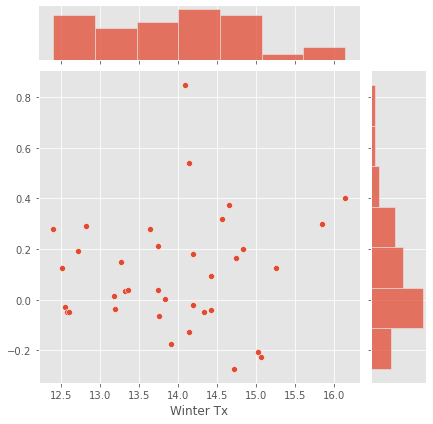

In [454]:
residual = df.loc[FIRST+WIDTH+1:LAST, 'Log price'] - predictions.loc[FIRST+WIDTH+1:LAST, 'Log Price']
sns.jointplot(x = df.loc[FIRST+WIDTH+1:LAST,'Winter Tx'], y = residual)
plt.show()

# Tree

Spearman: 0.3866159292112366


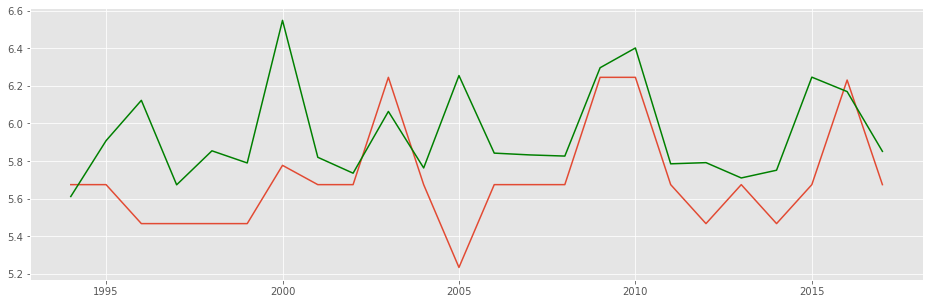

In [50]:
tree_features = ['Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)
X = X[tree_features]

X_train, X_test = X.loc[1961:1993], X.loc[1994:2017]
y_train, y_test = y.loc[1961:1993], y.loc[1994:2017]

dtree = DecisionTreeRegressor(max_depth=5)
dtree.fit(X_train,y_train.values.ravel())

predictions = dtree.predict(X_test)
plt.plot(range(1994, 2018),predictions)
plt.plot(y_test, color='green')
print('Spearman:', spearmanr(predictions, y_test).correlation)

from sklearn import tree

#tree.plot_tree(dtree)

In [274]:
FIRST, LAST = 1961, 2017
window_width = 32

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)[GOOD_FEATURES]
y = df[['Log price']]

def model_tester(X, y):
    r2_scores = []
    predictions = pd.DataFrame(index=range(FIRST + window_width +1,LAST +1), columns=['Log price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in range(FIRST, LAST - (window_width+1)):
        oldest_vintage = year
        newest_vintage = year + window_width

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        X_train = X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:]
        
        mod = DecisionTreeRegressor(max_depth=3)
        mod.fit(X_train, y_train.values.ravel())
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-FIRST+1:newest_vintage-FIRST+1,:]        
        predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    
    return r2_scores, spearman_scores, predictions

r2_scores, spearman_scores, predictions = model_tester(X, y)

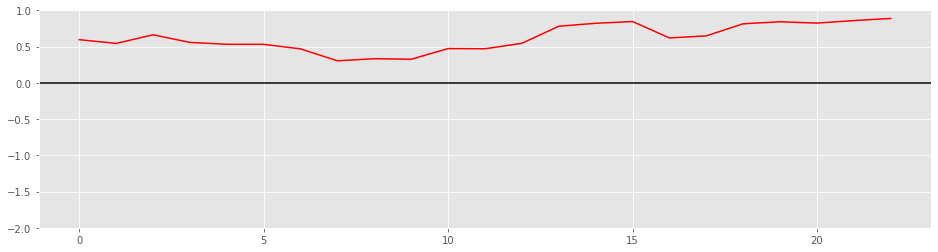

Average in-sample R2 score over the whole period:  0.6212244532251372


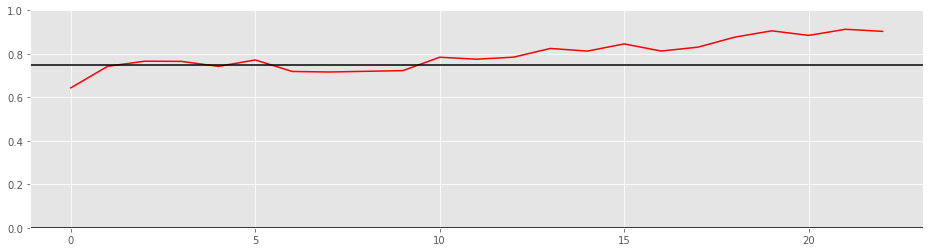

Average in-sample Spearman R over the whole period:  0.7941599346674536


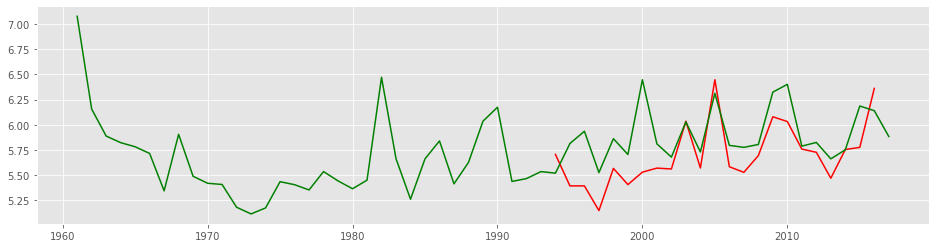

Average out-sample Spearman R over the target period:  0.5039525691699606


In [275]:
plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.ylim((0,1))
plt.axhline(0.75, color='black')
plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))


plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.show()
print('Average out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:2016], y.loc[1994:2016])[0])

# Appendix: PCA

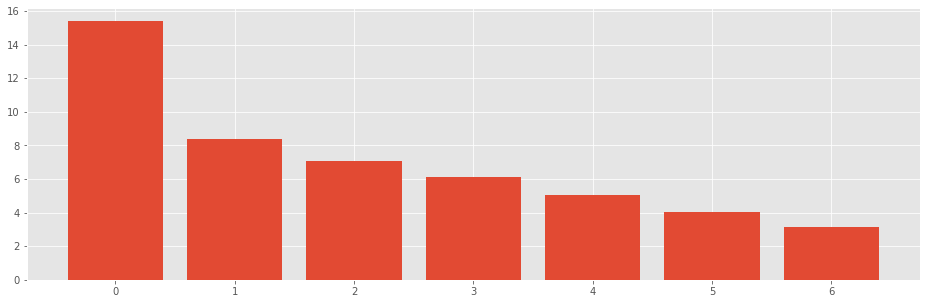

[[ 1.07229703e-01  1.77372448e-02  3.25866772e-02 -6.28067492e-02
  -1.51827176e-01 -1.85731390e-01 -1.72587283e-01 -1.64332756e-01
  -2.04996854e-01 -1.33071116e-01 -1.79317485e-01 -2.11510886e-01
  -4.28825347e-02 -2.91751155e-02 -3.94850983e-02  1.21743386e-01
  -1.56221227e-01  3.42567449e-04 -4.14579621e-02  2.49380874e-02
  -4.48762127e-02  1.12369662e-01 -1.89324475e-01 -1.20279056e-01
   1.65530467e-01 -6.39916896e-02  1.06910909e-01  2.06007265e-02
  -1.00271551e-01 -8.69559399e-02 -9.53385564e-02  9.84839213e-02
   1.66643401e-01  1.79711205e-01 -1.57649414e-01 -1.72346975e-01
  -2.10725068e-01  4.72527009e-02  1.10141911e-02 -1.42271697e-02
  -9.27670373e-02 -8.68814007e-02 -5.07254638e-02  2.72906044e-02
  -4.36906414e-03 -2.69188477e-03  7.14246182e-02 -5.09224662e-02
   1.85150233e-01  1.27782637e-01  1.95583671e-01  4.37811755e-02
  -4.16985944e-02  8.85613288e-02  1.99244324e-03 -7.43345406e-02
  -8.98160761e-02 -2.24451538e-01  1.73742128e-01 -1.06713329e-01
   1.18782

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

X = df.drop('Log price', axis=1).loc[1961:1994]
pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

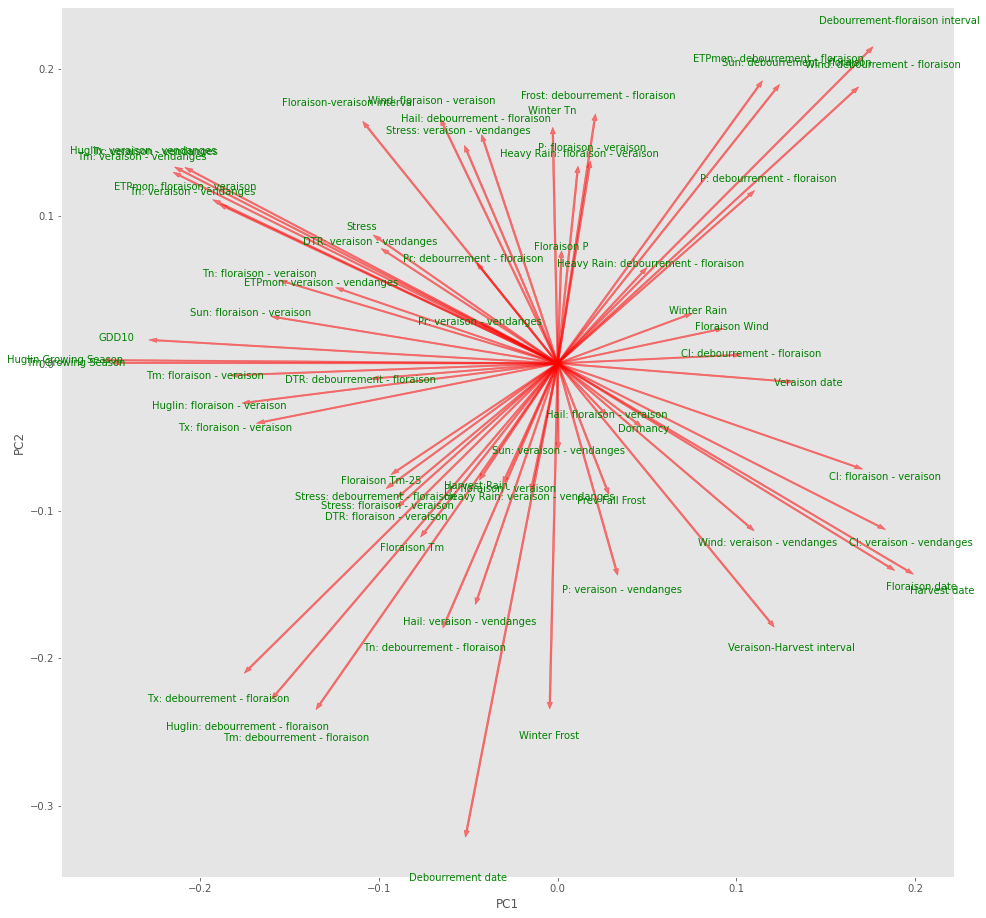

In [81]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,2]
    n = coeff.shape[0]
    #plt.scatter(xs ,ys) #without scaling
    for i in range(len(labels)):
        plt.arrow(0, 0, coeff[0,i], coeff[1,i],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, labels[i], color = 'g', ha = 'center', va = 'center')

plt.figure(figsize=(16,16))
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(X2.values[:,:], pca.components_, list(X.columns)) 
plt.show()

# 